In [2]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

In [158]:
def strobe(tvec,signal,period):
    n = 0
    strobedSignal = []
    strobedTime = []
    for t in tvec:
        if t % period == 0:
#             print(t)
            strobedTime.append(t)
            strobedSignal.append(signal[n])
        n += 1
    return [strobedTime, strobedSignal]

In [168]:
def computeSMI(X, Y, m, k):
    '''
    computes the sliced mutual information (see Goldfeld & Greenewald 2021)
        between X and Y with m slices.
    Assumes X has shape (dimX) X (obs) and Y has shape (dimY) X (obs) where
        'obs' is the number of observations.
    This code uses the KSG method for estimating mutual information, imported
        from sklearn.feature_selection
    '''
    print(k)
    dimX = X.shape[0]
    dimY = Y.shape[0]
    SMI = 0
    for mi in range(m):
        Theta = np.random.uniform(0,1,dimX)
        Phi = np.random.uniform(0,1,dimY)
        newX = np.dot(Theta,X)
        newX = np.reshape(newX, (len(newX),1))
        newY = np.dot(Phi,Y)
        Si = mutual_info_regression(newX, newY, n_neighbors=k)[0]
        SMI += Si/np.log(2)
    SMI = SMI/m
    return SMI

In [27]:
N = 10**4
mu = [0, 0, 0]
Sigma = np.array([[1, 0.5, 0.5],
                  [0.5, 1, 0.5],
                  [0.5, 0.5, 1]])
SigmaX = Sigma[0:2, 0:2]
# print(SigmaX)
SigmaY = Sigma[2,2]
# print(SigmaY)
detX = np.linalg.det(SigmaX)
detY = SigmaY
det = np.linalg.det(Sigma)
miAna = 0.5*np.log(detX*detY/det)/np.log(2)
print(f'analytical MI = {miAna} bits')

data = np.random.multivariate_normal(mu, Sigma, N)
# print(data.shape)
x0 = data[:,0]
x1 = data[:,1]
x2 = data[:,2]
# print(x0.shape)
X = np.array([x0,x1])
Y = np.array(x2)
Y = np.reshape(Y, (1,len(Y)))
print(X.shape[0])
print(Y.shape[0])
# print(X.shape)
m = 10 # number of slices
SMI = computeSMI(X, Y, m)
print(f'SMI = {SMI} bits')

analytical MI = 0.292481250360578 bits
2
1
SMI = 0.2789661239782282 bits


N = 10
N = 100
N = 1000
N = 10000
N = 100000
N = 1000000


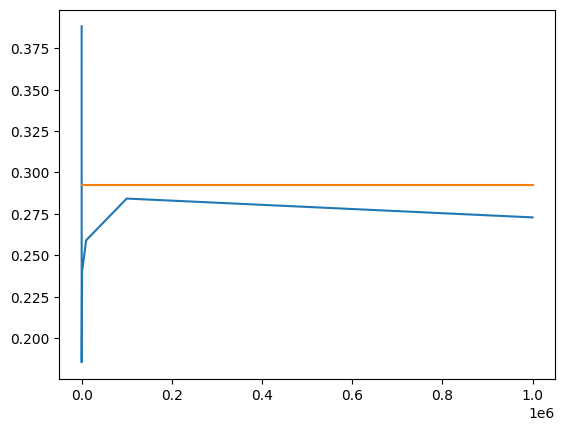

In [31]:
mu = [0, 0, 0]
Sigma = np.array([[1, 0.5, 0.5],
                  [0.5, 1, 0.5],
                  [0.5, 0.5, 1]])
m = 10 # number of slices

Nvec = np.logspace(1,6,6)
SMIvec = []
for N in Nvec:
    N = int(N)
    print(f'N = {N}')
    data = np.random.multivariate_normal(mu, Sigma, N)
    x0 = data[:,0]
    x1 = data[:,1]
    x2 = data[:,2]
    X = np.array([x0,x1])
    Y = np.array(x2)
    Y = np.reshape(Y, (1,len(Y)))
    SMI = computeSMI(X, Y, m)
    SMIvec.append(SMI)
plt.plot(Nvec, SMIvec)
plt.plot(Nvec, miAna*np.ones(len(Nvec)))

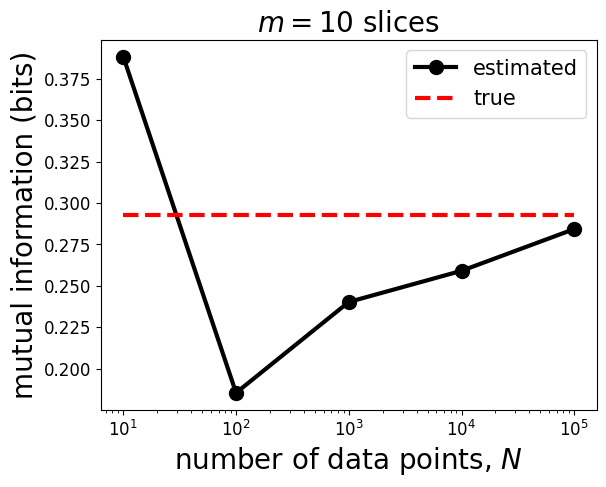

In [41]:
plt.plot(Nvec[:-1], SMIvec[:-1],marker='o',color='black',label='estimated',
        linewidth=3,markersize=10)
plt.plot(Nvec[:-1], miAna*np.ones(len(Nvec)-1),linestyle='--',color='red',
         label='true',linewidth=3)
plt.xscale('log')
plt.xlabel(r'number of data points, $N$',fontsize=20)
plt.ylabel('mutual information (bits)',fontsize=20)
plt.title(r'$m=10$ slices',fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
plt.savefig('SMIvN_mEq10.png',bbox_inches='tight',dpi=200)
plt.show()

m = 1
m = 2
m = 3
m = 4
m = 5
m = 6
m = 7
m = 8
m = 9
m = 10


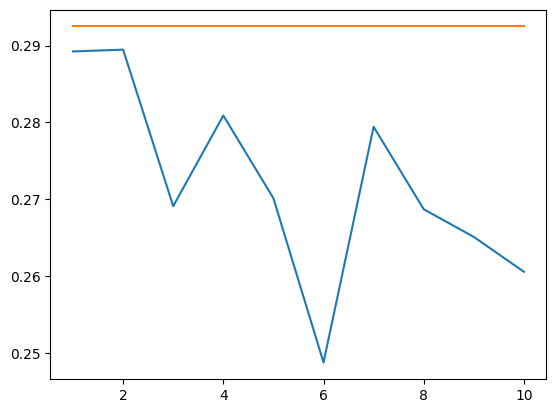

In [49]:
N = 10**5 # number of data points
data = np.random.multivariate_normal(mu, Sigma, N)
x0 = data[:,0]
x1 = data[:,1]
x2 = data[:,2]
X = np.array([x0,x1])
Y = np.array(x2)
Y = np.reshape(Y, (1,len(Y)))

# mvec = np.arange(10,110,10)
mvec = np.arange(1,11,1)
# print(mvec)
SMIvec = []
for m in mvec:
    N = int(N)
    m = int(m)
    print(f'm = {m}')
    SMI = computeSMI(X, Y, m)
    SMIvec.append(SMI)
plt.plot(mvec, SMIvec)
plt.plot(mvec, miAna*np.ones(len(mvec)))

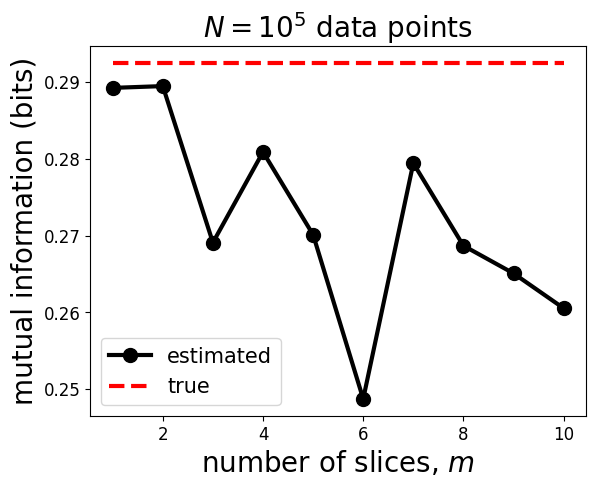

In [50]:
plt.plot(mvec, SMIvec,marker='o',color='black',label='estimated',
        linewidth=3,markersize=10)
plt.plot(mvec, miAna*np.ones(len(mvec)),linestyle='--',color='red',
         label='true',linewidth=3)
# plt.xscale('log')
plt.xlabel(r'number of slices, $m$',fontsize=20)
plt.ylabel('mutual information (bits)',fontsize=20)
plt.title(r'$N=10^5$ data points',fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
plt.savefig('SMIvm_NEq10to5.png',bbox_inches='tight',dpi=200)
plt.show()

In [111]:
# compute the rank of a spike train
def sTrainToRank(sTrain, delta_t, duration):
    """
    This function takes a spike train as input (a list of times when spikes occur)
    and returns a rank for that spike train by converting it to a binary sequence
    and converting that to a base 10 number.
    
    For example, a spike train sTrain = np.array([0.5,1.3,3.4,6.7,8.9,9.3]) would
    get converted to the string 1101001011 if a time bin delta_t=1 was used. This
    binary string would then be converted to 843 in base 10.
    
    sTrain = the list of spike times
    delta_t = the size of the time bin
    duration = the length of the time series to consider
    """
    Ts = int(duration) # consider time sequences of length 4*ms

    binTrain = np.zeros(Ts//delta_t)
    count = 0
    for j in range(len(binTrain)):
        state = int(0)
        for s in sTrain:
            condition = (s >= j*delta_t and s < (j+1)*delta_t)
            if condition:
                state = 1
                count += 1 # spike count
        binTrain[j] = int(state)

    # convert the list binTrain to a string
    
    binTrainStr=""
    for i in binTrain:
        binTrainStr += str(int(i))

    # convert the binary sequence to a number in base 10
    binTrainBase10 = int(binTrainStr, 2)
    ret = [binTrainBase10, binTrainStr, count]
    return ret

sTrain = np.array([0.5,1.3,3.4,6.7,8.9,9.3])
delta_t = 1
duration = 10
binTrainBase10, binTrainStr, count = sTrainToRank(sTrain, delta_t, duration)
print(binTrainBase10)
print(binTrainStr)
print(f'spike count = {count}')

843
1101001011
spike count = 6


Text(0, 0.5, 'voltage, v')

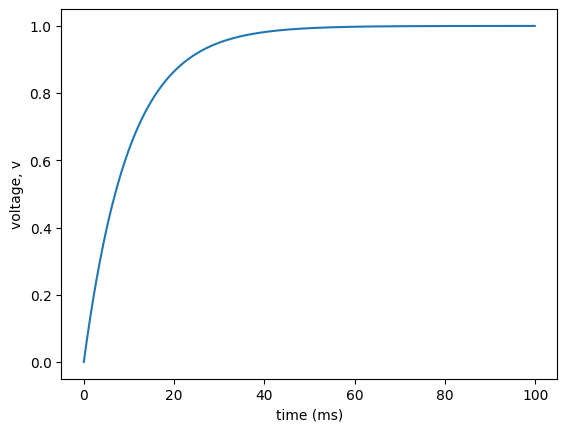

In [55]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = NeuronGroup(1, eqs, method='exact')
M = StateMonitor(G, ['v'], record=True)
run(100*ms)
plot(M.t/ms, M.v[0])
xlabel('time (ms)')
ylabel('voltage, v')

Text(0, 0.5, 'voltage, v')

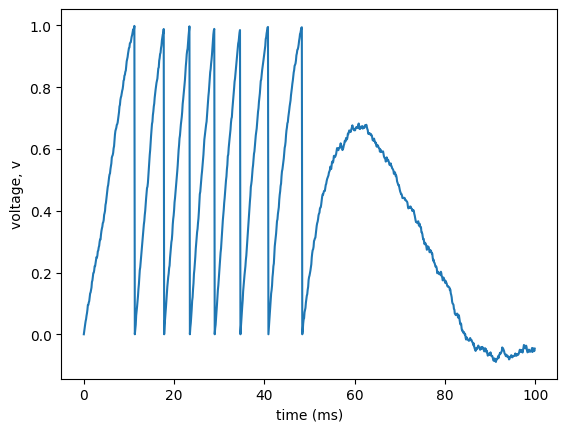

In [153]:
start_scope()
duration = 100*ms
dt = defaultclock.dt
tVec = np.arange(0,duration/ms+dt/ms,dt/ms)
noise = np.random.normal(0,0.5,len(tVec))
f1 = 5*Hz # frequency of I(t) in (Hz)
f2 = 10*Hz
f3 = 2*Hz
det = np.sin(2*np.pi*tVec*f1/(1000*Hz)) + np.sin(2*np.pi*tVec*f2/(1000*Hz)) - np.sin(2*np.pi*tVec*f3/(1000*Hz))
signal = det + noise
In = TimedArray(signal,dt)

tau = 10*ms
eqs = '''
dv/dt = (1-v+In(t))/tau : 1
'''

G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
M = StateMonitor(G, ['v'], record=True)
run(100*ms)
plot(M.t/ms, M.v[0])
xlabel('time (ms)')
ylabel('voltage, v')

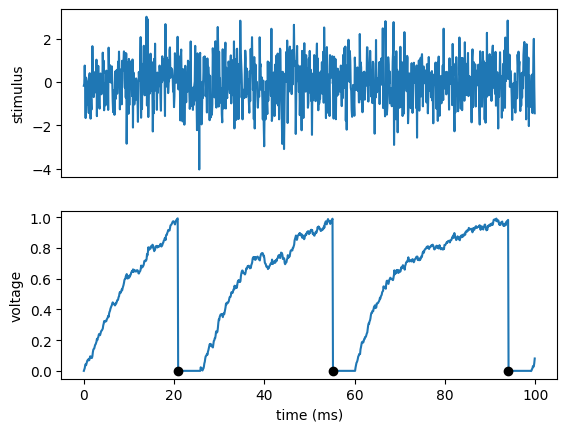

In [201]:
start_scope()
duration = 100*ms
dt = defaultclock.dt
tVec = np.arange(0,duration/ms+dt/ms,dt/ms)
noise = np.random.normal(0,1,len(tVec))
f1 = 5*Hz # frequency of I(t) in (Hz)
f2 = 10*Hz
f3 = 2*Hz
det = np.sin(2*np.pi*tVec*f1/(1000*Hz)) + np.sin(2*np.pi*tVec*f2/(1000*Hz)) - np.sin(2*np.pi*tVec*f3/(1000*Hz))
signal = det + noise
signal = noise
In = TimedArray(signal,dt)

tau = 10*ms
eqs = '''
dv/dt = (1-v+In(t))/tau : 1 (unless refractory)
'''

G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', refractory = 5*ms, method='exact')
M = StateMonitor(G, ['v'], record=True)
S = SpikeMonitor(G)
run(duration)

fig, ax = plt.subplots(2,1)
ax[0].plot(tVec, In)
ax[0].set_xticks([])
ax[0].set_ylabel('stimulus')
ax[1].plot(M.t/ms, M.v[0])
ax[1].plot(S.t/ms,np.zeros(len(S.t/ms)),marker='o',linestyle='',color='black')
ax[1].set_ylabel('voltage')
ax[1].set_xlabel('time (ms)')
plt.show()

In [90]:
print(S.t/ms)

[ 18.1  63.1  95.6 131.3 196.8 235.2 266.6 290.4 321.7 361.2]


In [100]:
def mod(n,m):
    if n < m:
        ret = 0
    else:
        ret = n % m
    return ret
print(mod(60,50))

10


In [103]:
st = S.t/ms
n0 = 0
stmod = []
for n in range(len(st)):
    spk = st[n]
    print(spk)
    if mod(spk,50) > 0:
        
        print('\tyes')
#         sub_st = st[n0]

18.1
63.1
	yes
95.60000000000001
	yes
131.3
	yes
196.8
	yes
235.20000000000002
	yes
266.6
	yes
290.4
	yes
321.70000000000005
	yes
361.2
	yes


In [114]:
print(duration)

10


In [216]:
T=50
st = S.t/ms % T
stOG = S.t/ms
delta_t = 5
stimVec = strobe(tVec,signal,T)[1]
rankVec = np.zeros(len(stimVec))
countVec = np.zeros(len(stimVec))
# countVec = []
print(f'st = {st}')
print(f'stOG = {stOG}')
print('\ndecomposed:')
n0 = 0
j = 0
for n in range(len(st)-1):
    if st[n+1] < st[n]:
        sub_st = st[n0:n+1]
#         print(sub_st)
        binTrainBase10, binTrainStr, count = sTrainToRank(sub_st, delta_t, T)
        print(f'{sub_st} = {binTrainStr} has rank {binTrainBase10} and spike count = {count}')
        rankVec[j] = binTrainBase10
        countVec[j] = count
        n0 = n+1
        j+=1
    if stOG[n+1] > duration/ms - T:
        print(stOG[n+1])
        sub_st = st[n+1:]
        binTrainBase10, binTrainStr, count = sTrainToRank(sub_st, delta_t, T)
        print(f'{sub_st} = {binTrainStr} has rank {binTrainBase10} and spike count = {count}')
        rankVec[j] = binTrainBase10
        countVec[j] = count
        break
#         j+=1
#     binTrainBase10, binTrainStr, count = sTrainToRank(sub_st, delta_t, T)
#     rankVec.append(binTrainBase10)
#     print(f'{sub_st} = {binTrainStr} has rank {binTrainBase10} and spike count = {count}')
#     countVec.append(count)
# stimVec = strobe(tVec,signal,T)[1]
print(f'\nstimVec = {stimVec}')
print(f'rankVec = {rankVec}')
print(f'countVec = {countVec}')

st = [20.8  5.1 44. ]
stOG = [20.8 55.1 94. ]

decomposed:
[20.8] = 0000100000 has rank 32 and spike count = 1
55.1
[ 5.1 44. ] = 0100000010 has rank 258 and spike count = 2

stimVec = [-0.17078537087210038, -0.47631127433402665, -1.4416594453753864]
rankVec = [ 32. 258.   0.]
countVec = [1. 2. 0.]


In [200]:
X = countVec
print(len(X))
X = np.reshape(X, (len(X),1))
Y = stimVec
print(len(Y))
Y = np.reshape(Y, (1,len(Y)))
k = 1 # number nearest neighbors
MIcount = computeSMI(X, Y, m, k)

3
3
1


ValueError: Found input variables with inconsistent numbers of samples: [1, 3]

In [190]:
T=50
st = S.t/ms % T
stOG = S.t/ms
delta_t = 5
spikeTrainLength = 50
rankVec = []
countVec = []
n0 = 0
for n in range(len(st)-1):
    if st[n+1] < st[n]:
        sub_st = st[n0:n+1]
        n0 = n+1
    if stOG[n+1] > duration/ms - 50:
        sub_st = st[n+1:]
    binTrainBase10, binTrainStr, count = sTrainToRank(sub_st, delta_t, spikeTrainLength)
    rankVec.append(binTrainBase10)
    countVec.append(count)
    
stimVec = strobe(tVec,signal,T)[1]
print(len(stimVec))
print(len(countVec))
print(len(rankVec))

101
129
129


In [187]:
X = np.array([countVec])
print(X.shape)
# print(len(X))
# X = np.reshape(X, (len(X),1))
Y = np.array([stimVec])
print(Y.shape)
# Y = np.reshape(Y, (1,len(Y)))
# # print(len(Y))
# # Y = np.reshape(Y, (1,len(Y)))
# k = 1 # number nearest neighbors
# MIcount = computeSMI(X, Y, m, k)

(1, 129)
(1, 101)


In [175]:
X = countVec
# print(len(X))
X = np.reshape(X, (len(X),1))
Y = stimVec
Y = np.reshape(Y, (len(Y),1))
# print(len(Y))
# Y = np.reshape(Y, (1,len(Y)))
k = 1 # number nearest neighbors
MIcount = computeSMI(X, Y, m, k)

133
1


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 1, n_neighbors = 2

In [138]:
SCs = np.unique(countVec) # all observed spike counts
# print(SCs)
for sc in SCs:
    print(f'spike count = {sc}')
#     idx = np.argwhere(countVec==sc)[:,0]
    idx = np.argwhere(countVec==sc)
    print(idx)
#     print(rankVec[idx])

spike count = 1
[[0]
 [1]
 [2]
 [3]
 [5]
 [6]
 [7]
 [8]]
spike count = 2
[[4]]


In [ ]:
    MItemp = 0.
    tot = duration*ms/T # total number of spike trains
    for key in ranksGivenCount:
        probSC = len(ranksGivenCount[key])/tot
        x = ranksGivenCount[key]
        x = np.reshape(x,(len(x),1))
        y = stimAvgsGivenCount[key]
        if len(x)>1: # don't use sub-samples with only 1 element
            mi = mutual_info_regression(x, y, n_neighbors=1)[0]
            MItemp+=probSC*mi
    return MItemp